# Examples of discontinuities

::: {#cell-1 .cell 0=‘h’ 1=‘i’ 2=‘d’ 3=‘e’ execution_count=14}

``` python
%load_ext autoreload
%autoreload 2
```

    The autoreload extension is already loaded. To reload it, use:
      %reload_ext autoreload

:::

In [15]:
# /// pyproject
# run.requirements = [
#   "pyyaml",
#   "pydantic",
#   "pyspedas",
#   "pytplot",
#   "matplotlib",
#   "scienceplots",
# ]
# /

import sys
import yaml

from pydantic import constr, BaseModel
from datetime import datetime, date

import pyspedas
from pyspedas.cotrans.minvar_matrix_make import minvar_matrix_make
from pyspedas import tvector_rotate
from pyspedas.analysis.tvectot import tvectot

from pytplot import join_vec, split_vec, get_data
from pytplot import tplot, options, tlimit

from utils import Config, PanelConfig, OutputConfig, ProcessConfig, export

import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "nature", "notebook"])
plt.rc("savefig", dpi=300)
# plt.rc('svg', fonttype='none')

In [16]:
file_path = sys.argv[1]

In [17]:
config = yaml.load(open(file_path), Loader=yaml.FullLoader)
config = Config(**config)
tvars2plot = []

20-Jan-24 15:16:21: /var/folders/tg/rfd0nr_970s3mv1fspgvkkxm0000gn/T/ipykernel_38779/3996895581.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='config_examples/examples_stereo.yml' mode='r' encoding='UTF-8'>
  config = yaml.load(open(file_path), Loader=yaml.FullLoader)


In [18]:
def load_data(config: PanelConfig, load_func=None):
    
    if load_func is None:
        mod = getattr(pyspedas, config.satellite)
        load_func = getattr(mod, config.instrument)
    
    
    load_args = {
        "trange": [ time.isoformat() for time in config.timerange],
        "time_clip": True,
        'varnames': config.id,
    }
    
    # Conditionally add the 'datatype' and 'probe' argument
    if config.datatype is not None:
        load_args["datatype"] = config.datatype
    if config.probe is not None:
        load_args["probe"] = config.probe
        
    return load_func(**load_args)

In [19]:
def process(tvar, config: ProcessConfig):
    
    trans = config.trans
    if config.trans:
        if "slice-3" in config.trans:
            tvar = join_vec(split_vec(tvar)[:3])
        if "mva" in config.trans:
            minvar_matrix_make(tvar)
            tvar = tvector_rotate(tvar + "_mva_mat", tvar)[0]
            legend_names = [r"$B_l$", r"$B_m$", r"$B_n$"]

        if "magnitude" in trans:
            tvar2plot = tvectot(tvar, join_component=False)    
            options(tvar2plot, "legend_names", None)
        
        if "magnitude_join" in trans:
            tvar2plot = tvectot(tvar, join_component=True)
            legend_names = legend_names + [r"$B_{total}$"]
            options(tvar2plot, "legend_names", legend_names)

    else:
        tvar2plot = tvar
    
    return tvar2plot


In [20]:
def update_tvar(tvar, config: PanelConfig):
    options(tvar, "thick", 2)
    # options(tvar, "char_size", 16)
    if config.name:
        options(tvar, "ytitle", f"{config.name}")
    if config.units:
        options(tvar, "ysubtitle", f"[{config.units}]")

    return tvar


def process_panel(config: PanelConfig):
    tvar = load_data(config)

    if isinstance(tvar, list):
        tvar = tvar[0]

    if config.process is not None:
        tvar = process(tvar, config=config.process)
    tvar_updated = update_tvar(tvar, config=config)

    return tvar_updated

In [21]:
for p_config in config.panels:
    tvar2plot = process_panel(p_config)
    tvars2plot.append(tvar2plot)

20-Jan-24 15:16:21: Downloading remote index: http://sprg.ssl.berkeley.edu/data/misc/stereo/impact/level1/ahead/mag/RTN/2016/06/
20-Jan-24 15:16:22: File is current: /Users/zijin/data/stereo/impact/level1/ahead/mag/RTN/2016/06/STA_L1_MAG_RTN_20160628_V06.cdf
20-Jan-24 15:16:30: Time clip was applied to: BFIELD

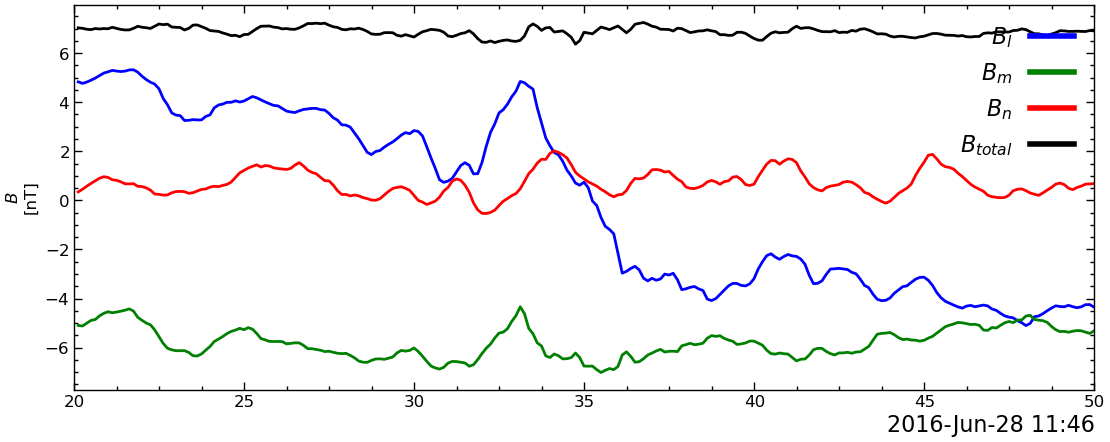

In [22]:
# tlimit([ time.isoformat() for time in config.timerange])
export(config.output, tvars2plot)